<a href="https://colab.research.google.com/github/Jubayer934/Pneumonia-Detection-by-Symptoms-X-ray-Report/blob/main/pneumonia_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==============================
# Connect google drive and load the dataset
# ==============================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in Drive
zip_path = "/content/drive/MyDrive/ModelTrain/Pneumonia/dataset/chest_xray.zip"

# Unzip it to /content/
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/pneuminia_dataset")

# Set dataset path
dataset_path = "/content/pneuminia_dataset/chest_xray"

In [ ]:
import os

# List top-level files/folders
print(os.listdir("/content/pneuminia_dataset/chest_xray"))

# If it's nested, explore further:
for root, dirs, files in os.walk("/content/pneuminia_dataset/chest_xray"):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files[:5])  # just print the first 5 files
    print("===")

['val', 'train', '.DS_Store', 'test']
Root: /content/pneuminia_dataset/chest_xray
Dirs: ['val', 'train', 'test']
Files: ['.DS_Store']
===
Root: /content/pneuminia_dataset/chest_xray/val
Dirs: ['NORMAL', 'PNEUMONIA']
Files: ['.DS_Store']
===
Root: /content/pneuminia_dataset/chest_xray/val/NORMAL
Dirs: []
Files: ['NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1438-0001.jpeg', 'NORMAL2-IM-1442-0001.jpeg', 'NORMAL2-IM-1437-0001.jpeg']
===
Root: /content/pneuminia_dataset/chest_xray/val/PNEUMONIA
Dirs: []
Files: ['person1946_bacteria_4874.jpeg', 'person1951_bacteria_4882.jpeg', 'person1950_bacteria_4881.jpeg', 'person1947_bacteria_4876.jpeg', 'person1949_bacteria_4880.jpeg']
===
Root: /content/pneuminia_dataset/chest_xray/train
Dirs: ['NORMAL', 'PNEUMONIA']
Files: ['.DS_Store']
===
Root: /content/pneuminia_dataset/chest_xray/train/NORMAL
Dirs: []
Files: ['IM-0495-0001.jpeg', 'IM-0439-0001-0001.jpeg', 'NORMAL2-IM-0775-0001.jpeg', 'NORMAL2-IM-1098-0001.jpeg', 'NORMAL2-I

# ==============================
# Module Imports
# ==============================


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available:", tf.config.list_physical_devices('GPU'))
else:
    print("❌ GPU not available.")

✅ GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# ==============================
# Dataset Preparation
# ==============================


In [ ]:
# Define image parameters
IMAGE_SIZE = (224, 224) # VGG16 was originally trained on 224x224 images
BATCH_SIZE = 32
NUM_CLASSES = 2 # Pneumonia and Normal

In [ ]:
# --- Training Data Generator (with augmentation) ---
train_datagen = ImageDataGenerator(
    rescale=1./255, # Rescale pixel values to 0-1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# --- Flow from Directory ---
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # Use 'binary' for 2 classes (Pneumonia/Normal)
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Important for testing to keep order for evaluation
)

print("Class Indices:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}


# ========================================
# Build the VGG16 Transfer Learning Model
# ========================================

In [ ]:
# 1. Load the pre-trained VGG16 model (Convolutional Base)
vgg_base = VGG16(
    weights='imagenet',          # Use pre-trained weights from ImageNet
    include_top=False,           # Exclude the original classification layers
    input_shape=IMAGE_SIZE + (3,) # Define input shape (224, 224, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 2. Freeze the base layers
# This prevents the pre-trained weights from being updated during training.
for layer in vgg_base.layers:
    layer.trainable = False

In [ ]:
# 3. Add custom classification layers (Head)
x = vgg_base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
# Final output layer: 1 neuron with 'sigmoid' activation for binary classification
predictions = Dense(1, activation='sigmoid')(x)

# 4. Create the final model
model = Model(inputs=vgg_base.input, outputs=predictions)

In [ ]:
# Display the model structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# ============================
# Compile and Train the Model
# ============================

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower learning rate is often better for transfer learning
    loss='binary_crossentropy', # Use binary_crossentropy for 2 classes and sigmoid output
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath="/content/drive/MyDrive/ModelTrain/Pneumonia/model/pnumonia_image_model.keras",  # Path to save the model
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model based on the monitored metric
    mode='max',  # Save when the monitored metric is maximized (for accuracy)
    verbose=1 # Print messages when saving
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10, # Start with a small number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint_callback] # Add the ModelCheckpoint callback
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9356 - loss: 0.1704
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to /content/drive/MyDrive/ModelTrain/Pneumonia/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 673ms/step - accuracy: 0.9355 - loss: 0.1705 - val_accuracy: 0.7500 - val_loss: 0.4383
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9341 - loss: 0.1586
Epoch 2: val_accuracy improved from 0.75000 to 0.81250, saving model to /content/drive/MyDrive/ModelTrain/Pneumonia/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 669ms/step - accuracy: 0.9341 - loss: 0.1586 - val_accuracy: 0.8125 - val_loss: 0.4264
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.9403 - loss: 0.1474
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 675ms/step - accuracy: 0.9403 - loss: 0.1474 - val_accuracy: 0.8125 - val_loss: 0.3285
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9

In [ ]:
# Evaluate on the test set
print("Evaluating on Test Set...")
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating on Test Set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.8585 - loss: 0.4222
Test Loss: 0.2835
Test Accuracy: 0.9038


In [ ]:
from sklearn.metrics import classification_report

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

class_names = list(test_generator.class_indices.keys())

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.78      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



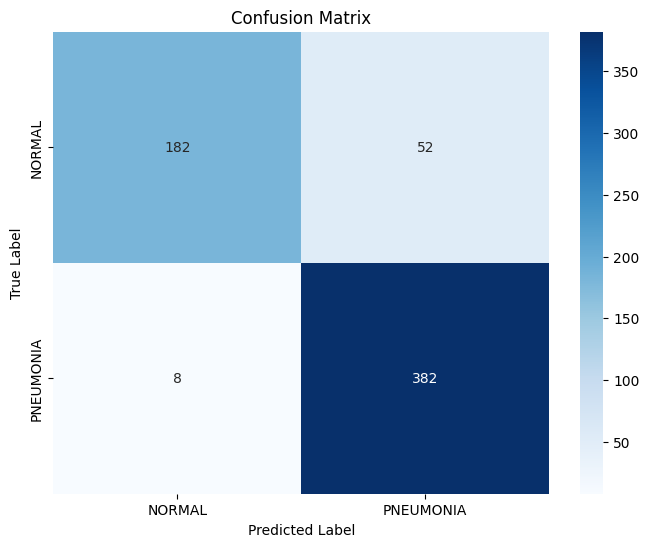

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

# Define the path to the image
image_path = "/content/pneuminia_dataset/chest_xray/test/NORMAL/IM-0001-0001.jpeg"

# Load the image
img = image.load_img(image_path, target_size=IMAGE_SIZE)

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's input shape (add batch dimension)
img_array = np.expand_dims(img_array, axis=0)

# Rescale the image like the training data
img_array /= 255.0

# Make the prediction
prediction = model.predict(img_array)

# Get the confidence (probability)
confidence_pneumonia = prediction[0][0]
confidence_normal = 1 - confidence_pneumonia

# Get the class index with the highest probability
predicted_class_index = int(round(confidence_pneumonia))

# Get the class name
class_names = list(test_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class_index]

# Print the prediction and confidence
print(f"The predicted class for the image is: {predicted_class_name}")
print(f"Confidence for {class_names[1]}: {confidence_pneumonia:.4f}")
print(f"Confidence for {class_names[0]}: {confidence_normal:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
The predicted class for the image is: NORMAL
Confidence for PNEUMONIA: 0.0267
Confidence for NORMAL: 0.9733


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
import cv2
import os

# Define the path to the saved model (the best one from training)
model_path = "/content/drive/MyDrive/ModelTrain/Pneumonia/model/pnumonia_image_model.keras" # Or .h5 depending on how it was saved

# Load the trained model
loaded_model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

# Define image size (should be the same as used for training)
IMAGE_SIZE = (224, 224)

# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array /= 255.0 # Rescale
    return img_array

# Function to make prediction
def predict_pneumonia(img_array):
    prediction = loaded_model.predict(img_array)
    # For binary classification with sigmoid, the output is a probability
    confidence_pneumonia = prediction[0][0]
    confidence_normal = 1 - confidence_pneumonia

    # Get the class index with the highest probability
    predicted_class_index = int(round(confidence_pneumonia))

    # Get the class name (assuming 'NORMAL': 0, 'PNEUMONIA': 1 from training)
    class_names = {0: 'NORMAL', 1: 'PNEUMONIA'} # Define class names explicitly or get from generator if available
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name, confidence_pneumonia, confidence_normal

# Upload an image
uploaded = files.upload()

for fn in uploaded.keys():
    # Get the path to the uploaded image
    img_path = fn

    # Preprocess the image
    processed_img = preprocess_image(img_path)

    # Make prediction
    predicted_class, conf_pneumonia, conf_normal = predict_pneumonia(processed_img)

    # Print the results
    print(f"\nUploaded image: {fn}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence for PNEUMONIA: {conf_pneumonia:.4f}")
    print(f"Confidence for NORMAL: {conf_normal:.4f}")

    # Optional: Display the uploaded image
    # img = cv2.imread(img_path)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.title(f"Prediction: {predicted_class}")
    # plt.axis('off')
    # plt.show()

    # Clean up the uploaded file
    os.remove(img_path)

Model loaded successfully!


Saving IM-0003-0001.jpeg to IM-0003-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step

Uploaded image: IM-0003-0001.jpeg
Predicted class: NORMAL
Confidence for PNEUMONIA: 0.0866
Confidence for NORMAL: 0.9134
